In [ ]:
pip install pandas numpy scikit-learn matplotlib yfinance


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import yfinance as yf


In [ ]:
# Download Apple stock data
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2023-01-01")

# Calculate moving averages and relative price change
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Price_Change'] = data['Close'].pct_change()

# set target as next days close
data['Target'] = data['Close'].shift(-1)

# Drop rows with NaN values
data.dropna(inplace=True)

#print(data.head())

In [ ]:
# Features and target
X = data[['SMA_10', 'SMA_50', 'Price_Change']]
y = data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


<h1> GridSearch setup </h1>

In [ ]:
# Define the different hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [None, 10, 20, 30],        # Maximum depth of trees
    'min_samples_split': [2, 5, 10],        # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples per leaf node
}

In [ ]:
#training
model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_absolute_error',         # Use mse as scoring
    verbose=2,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)


In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
for i, row in results_df.iterrows():
    print(f"Rank {row['rank_test_score']}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean Test Score: {row['mean_test_score']:.4f}")
    print(f"Std Dev of Test Score: {row['std_test_score']:.4f}")
    print("-" * 30)

Final Model MAE: 1.535209008088245
Final Model RMSE: 2.611168629625419


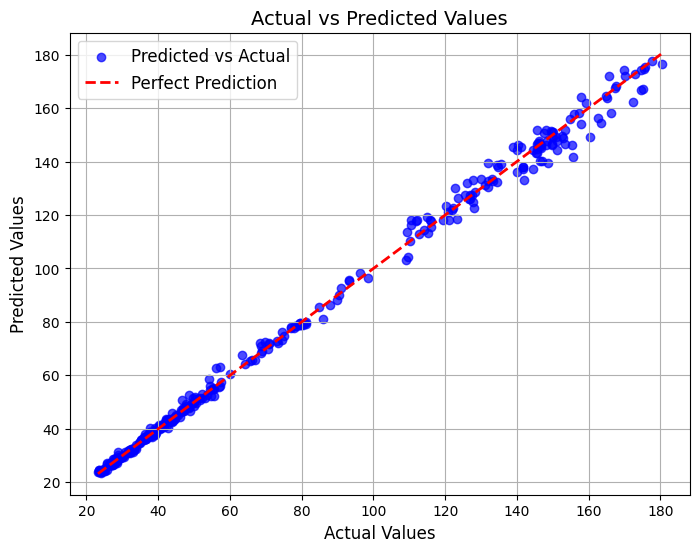

In [29]:
# Extract best parameters
best_params = grid_search.best_params_

# Train the final model with best parameters
final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict on test data
final_predictions = final_model.predict(X_test)

# Evaluate the final model
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")


# Visualize Predictions vs. Actual Outcomes
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, alpha=0.7, color='b', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')  # Diagonal line
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()